In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split

– Feature Engineeringをせず与えられた特徴量のみ使用した<br>
– 外れ値の確認を行っていない<br>
– 機械学習アルゴリズム。線形と木とSVRでGrid Searchにホイッという手抜きぶり

In [2]:
#学習データとテストデータの読み込み
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
#予測に使わないIdを保持・データフレームから削除
df_train_index = df_train["Id"]
df_test_index = df_test["Id"]
df_train.drop(["Id"], axis=1, inplace=True)
df_test.drop(["Id"], axis=1, inplace=True)

In [4]:
#目的変数であるSalePriceを別に取っておく
y_train = df_train["SalePrice"].values
df_train.drop(["SalePrice"], axis=1, inplace=True)

In [5]:
#学習用データとテストデータを一度統合する
df_all = pd.concat((df_train,df_test)).reset_index(drop=True)

In [6]:
#欠損値の個数確認 / 2919データ
df_all.isnull().sum()[df_all.isnull().sum() != 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

In [7]:
#欠損値の補完
#以下はNaN = NAかNoneの特徴量リスト。よって欠損値をそれぞれNAとNoneで補完する。
df_all["PoolQC"].fillna('NA', inplace=True)
df_all["MiscFeature"].fillna('None', inplace=True)
df_all["Alley"].fillna('NA', inplace=True)
df_all["Fence"].fillna('NA', inplace=True)
df_all["FireplaceQu"].fillna('NA', inplace=True)
df_all["GarageQual"].fillna('NA', inplace=True)
df_all["GarageFinish"].fillna('NA', inplace=True)
df_all["GarageCond"].fillna('NA', inplace=True)
df_all["GarageType"].fillna('NA', inplace=True)
df_all["BsmtCond"].fillna('NA', inplace=True)
df_all["BsmtExposure"].fillna('NA', inplace=True)
df_all["BsmtQual"].fillna('NA', inplace=True)
df_all["BsmtFinType2"].fillna('NA', inplace=True)
df_all["BsmtFinType1"].fillna('NA', inplace=True)
df_all["MasVnrType"].fillna('None', inplace=True)

#以下はNaN = 0の特徴量リスト。例えば地下なら、地下がないんだから0。みたいな。
df_all["GarageYrBlt"].fillna(0, inplace=True) # ガレージ築年数を0にするのも不思議な気はしますが、そもそもガレージがないので他に妥当な数字が思いつかず。
df_all["MasVnrArea"].fillna(0, inplace=True)
df_all["BsmtHalfBath"].fillna(0, inplace=True)
df_all["BsmtFullBath"].fillna(0, inplace=True)
df_all["TotalBsmtSF"].fillna(0, inplace=True)
df_all["BsmtUnfSF"].fillna(0, inplace=True)
df_all["BsmtFinSF2"].fillna(0, inplace=True)
df_all["BsmtFinSF1"].fillna(0, inplace=True)
df_all["GarageArea"].fillna(0, inplace=True)
df_all["GarageCars"].fillna(0, inplace=True)

#欠損レコード数が少なく、大半が一つの値をとっているためあまりに予測の役に立たなさそうな特徴量は単純に最頻値を代入
df_all["MSZoning"].fillna('RL', inplace=True)
df_all["Functional"].fillna('Typ', inplace=True)
df_all["Utilities"].fillna("AllPub", inplace=True)
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])
df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])
df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])
df_all['Electrical'] = df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])

#LotFrontage - Linear feet of street connected to property
#これは補完方法が明らかかつ簡単で、近くのStreet名=Neighborhoodでグループし平均を取れば良い精度で補完できそう。
f = lambda x: x.fillna(x.mean())
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(f)

In [8]:
#欠損値がすべて補完されているか確認
df_all.isnull().sum()[df_all.isnull().sum() != 0].sort_values(ascending=False)

Series([], dtype: int64)

In [9]:
#One Hot Encoding
df_all = pd.get_dummies(df_all)

In [10]:
#日本人なら気になる、「で、何LDKなの？」
df_all['xLDK'] = df_all['BedroomAbvGr'] + df_all['KitchenAbvGr']
#何年に建ったかより、築年数の方が重要のはず
df_all['YearSinceBuilt'] = 2018 - df_all['YearBuilt']
#何年に売れたかより、売れてから経過している年数の方が重要のはず
df_all['YrSinceSold'] = 2018 - df_all['YrSold']
#ガレージの築年数
df_all['GarageSinceYrBlt'] = 2018 - df_all['GarageYrBlt']
#大きなくくりで集計してみる
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch'] + df_all['OpenPorchSF'] + df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_all['TotalHouseSF'] = df_all['1stFlrSF'] + df_all['2ndFlrSF'] + df_all['TotalBsmtSF']
#なんかLow Qualityな面積があるらしいので全体の面積から引く
df_all['TotalHouseSFHighQuality'] = df_all['TotalHouseSF'] - df_all['LowQualFinSF']
#割るぞ～
df_all['1stFlr_vs_2ndFlr'] = df_all['1stFlrSF'] / (df_all['2ndFlrSF'] + 0.001)
df_all['Bsmt_vs_1stAnd2ndFlr'] = df_all['TotalBsmtSF'] / (df_all['1stFlrSF'] + df_all['2ndFlrSF'] + 0.001)
#Overall Qualityが結構重要そうなので2乗と3乗してみる
df_all['OverallQual_2'] = df_all['OverallQual']**2
df_all['OverallQual_3'] = df_all['OverallQual']**3


df_all['Pooldammy'] = (df_all['PoolArea'] > 0) * 1


In [11]:
#学習用データとテストデータを切り分ける
ntrain = df_train.shape[0]
train = df_all[:ntrain]
test = df_all[ntrain:]
y = y_train
#X = train.loc[:, train.columns != 'SalePrice']

In [12]:
#Isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=1234,n_estimators=500, contamination=0.01)
clf.fit(train)

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination=0.01,
        max_features=1.0, max_samples='auto', n_estimators=500,
        n_jobs=None, random_state=1234, verbose=0)

In [13]:
mv_outliers = pd.DataFrame(clf.predict(train))
mv_outliers.columns = ['OutlierFlag']

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [14]:
mv_outliers[mv_outliers == -1].count()

OutlierFlag    15
dtype: int64

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


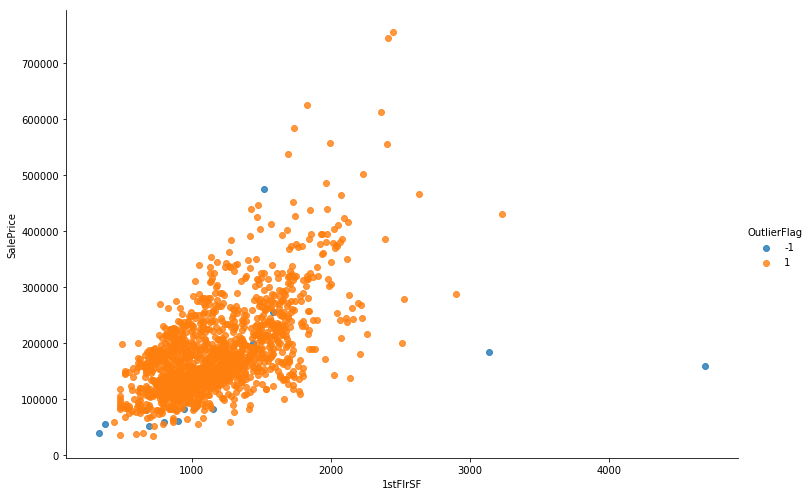

In [15]:
y_train = pd.DataFrame(y_train)
y_train.columns = ['SalePrice']
df_all_olcheck = pd.concat([mv_outliers,train, y_train], axis=1)
ax = sns.lmplot(x='1stFlrSF', y='SalePrice',fit_reg=False,
data=df_all_olcheck, hue='OutlierFlag', size=7, aspect=1.5)

In [16]:
df_all_r1 = df_all_olcheck[df_all_olcheck['OutlierFlag'] == 1]
df_all_r1.drop("OutlierFlag", axis=1, inplace=True)
y_train_r1 = df_all_r1["SalePrice"].values
df_all_r1.drop(["SalePrice"], axis=1, inplace=True)
#30%でチューニングを行う
X_train, X_test, y_train, y_test = train_test_split(df_all_r1, y_train_r1, test_size=0.3, random_state=1234)
#とりあえずランダムフォレスト、パラメーターは前回のグリッドサーチ結果と同様
rf = RandomForestRegressor(n_estimators = 500, max_depth=10, random_state=1234)
rf.fit(X_train,y_train)

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [17]:
y_pred2 = rf.predict(X_test)
print("ランダムフォレストでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred2)))

ランダムフォレストでのRMSE: 24560.984726959774


In [1]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(max_depth=5, n_estimators=500, subsample=0.8)
xgb_reg.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [ ]:
#RMSE
y_pred3 = xgb_reg.predict(X_test)
print("xgboostでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

In [ ]:
from xgboost import plot_importance

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
plot_importance(xgb_reg, ax=ax, max_num_features=20)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = MinMaxScaler()
X_train_svr = scaler.fit_transform(X_train)
X_test_svr = scaler.transform(X_test)
#SVR
svr = svm.SVR(C=1e6,epsilon=0.2,kernel='rbf')
svr.fit(X_train_svr, y_train)
#RMSE
y_pred = svr.predict(X_test_svr)
print("SVRでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
#まだ予測値を取得していないラッソ回帰
lasso = Lasso(normalize=True, random_state=123, max_iter=10000)
lasso.fit(X_train,y_train)

In [ ]:
y_pred4 = lasso.predict(X_test)
print("LassoでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred4)))

In [ ]:
#SVRはy_pred, xgboostはy_pred3, Lassoはy_pred4
y_stack = y_pred*(1/3) + y_pred3*(1/3) + y_pred4*(1/3)
print("StackingでのRMSE:",np.sqrt(mean_squared_error(y_test, y_stack)))

In [ ]:
y_pred_lasso = lasso.predict(test)
y_pred_xgb = xgb_reg.predict(test)
test_svr = scaler.transform(test)
y_pred_svr = svr.predict(test_svr)
y_stack = y_pred_svr*(1/3) + y_pred_xgb*(1/3) + y_pred_lasso*(1/3)

In [ ]:
submission = pd.concat((df_test_index, pd.DataFrame(y_stack)), axis=1)
submission.columns = ['Id', 'SalePrice']
submission.to_csv("sample2.csv",sep=',',index=False)